<a href="https://colab.research.google.com/github/Martindelosrios/BATMAN/blob/master/EXAMPLES/Example_1_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Example 1

Here we will learn how to use BATMAN for estimating the parameter posteriors given data from XENONnT experiment

# First let's install BATMAN from https://github.com/Martindelosrios/BATMAN

In [1]:
!git clone https://github.com/Martindelosrios/BATMAN.git

Cloning into 'BATMAN'...
remote: Enumerating objects: 520, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 520 (delta 57), reused 63 (delta 28), pack-reused 415
Receiving objects: 100% (520/520), 47.32 MiB | 20.01 MiB/s, done.
Resolving deltas: 100% (287/287), done.
Updating files: 100% (28/28), done.


In [2]:
!pip install BATMAN/

Processing ./BATMAN
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 850.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.5/208.5 kB 23.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56

# Let's load the needed packages and data

In [1]:
from BATMAN import batman, models
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py
import pkg_resources
from importlib_resources import files

from scipy.integrate import trapezoid
from matplotlib.lines import Line2D

/home/martinrios/.virtualenvs/BATMAN/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/martinrios/.virtualenvs/BATMAN/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.

Using GPU


In [2]:
# Some fancy colour configuration
color_rate = "#d55e00"
color_drate = "#0072b2"
color_s1s2 = "#009e73"

In [3]:
# Now let's load the dataset with XENON nT simulations.
#  This data was create with .....

ref = files("BATMAN") / "dataset/"
DATA_PATH = str(ref)
with h5py.File(DATA_PATH + "/testset.h5", "r") as data:
  x_norm_rate  = data['x_norm_rate'][()]
  x_norm_drate = data['x_norm_drate'][()]
  x_norm_s1s2  = data['x_norm_s1s2'][()]
  pars_norm    = data['pars_norm'][()]
  pars_min = data.attrs["pars_min"]
  pars_max = data.attrs["pars_max"]
  x_min_rate = data.attrs["x_min_rate"]
  x_max_rate = data.attrs["x_max_rate"]
  x_min_drate = data.attrs["x_min_drate"]
  x_max_drate = data.attrs["x_max_drate"]


# Let's play with BATMAN!

In [4]:
# Let's pick some random synthetic observation from the simulated dataset.

i = np.random.randint(len(pars_norm))
print('nobs = ' + str(i))

pars_true   = pars_norm[i,:]
x_obs_rate  = x_norm_rate[i,:]
x_obs_drate = x_norm_drate[i,:]
x_obs_s1s2  = x_norm_s1s2[i,:].reshape(1,96,96)

M_DM_real = 10**(pars_true[0] * (pars_max[0] - pars_min[0]) + pars_min[0])
print('M_DM = {:.2f} GeV'.format(M_DM_real))
sigma_real = 10**(pars_true[1] * (pars_max[1] - pars_min[1]) + pars_min[1])
print('sigma = {:.3e} cm2'.format(sigma_real))
theta_real = (pars_true[2] * (pars_max[2] - pars_min[2]) + pars_min[2])
print('theta = {:.3} '.format(theta_real))

nobs = 320
M_DM = 358.96 GeV
sigma = 1.641e-47 cm2
theta = -0.581 


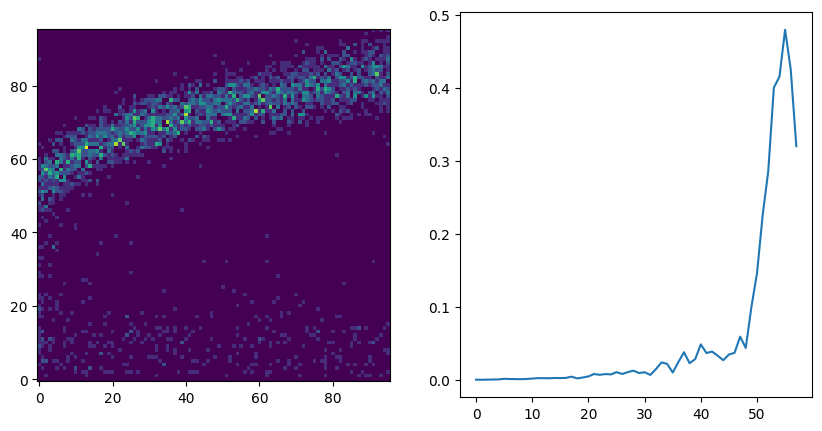

In [5]:
# Let's see how it looks

fig,ax = plt.subplots(1,2, figsize = (10,5))

ax[0].imshow(x_obs_s1s2.T, origin = 'lower')

ax[1].plot(x_obs_drate)

Now let's check the available models...

As you can see, when doing print(model) you have some information about the available models

In [6]:
# Now let's check the available models...

print('--------------------------------')
print('For analyzing s1s2 images we have:')

print(models.XENONnT_O1_s1s2)

print('--------------------------------')
print('For analyzing differential rate data we have:')

print(models.XENONnT_O1_drate)

print('--------------------------------')
print('For analyzing total rate data we have:')

print(models.XENONnT_O1_rate)

--------------------------------
For analyzing s1s2 images we have:

    This model was trained using synthetic data of the expected S1S2
    signal in xenonNT for dark matter particles with O(1)
    with :math:`M_{dm} in [6-1000] GeV`, :math:`sigma = [10^{-50}-10^{-43}] cm^{2}`
    and :math:`	heta = [-pi/2-pi/2]`.
    In order to analyse a new data x it must be a np.array with shape (n,1,97,70),
    where n is the number of observations to be analysed.

    You can extract the 1D marginal posteriors of each parameter or the 2D
    marginal posteriors of combination of parameters.

 NOT TRAINED 

--------------------------------
For analyzing differential rate data we have:

    This model was trained using synthetic data of the expected differential
    rate in xenonNT for dark matter particles with O(1)
    with :math:`M_{dm} in [6-1000] GeV`, :math:`sigma = [10^{-50}-10^{-43}] cm^{2}`
    and :math:`theta = [-pi/2-pi/2]`.
    In order to analyse a new data x it must be a np.array w

As you can see, the models are not trained yet!!!
This can also be check by doing:

```python
model.trained_flag()
```

Anyway, as these models were pre-trained in arxiv XXXX.XXXX
you can load the saved weights just doing

```python
model.load_weights()
```



In [7]:
models.XENONnT_O1_rate.load_weights()
models.XENONnT_O1_drate.load_weights()
models.XENONnT_O1_s1s2.load_weights()

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at /home/martinrios/martin/trabajos/BATMAN/BATMAN/dataset/O1_rate.ckpt


Training model...
Reading weights from 

/home/martinrios/martin/trabajos/BATMAN/BATMAN/dataset/O1_rate.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/martinrios/martin/trabajos/BATMAN/BATMAN/dataset/O1_rate.ckpt
/home/martinrios/.virtualenvs/BATMAN/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0:  58%|██████████████████████████                   | 11/19 [00:00<00:00, 93.00it/s]

/home/martinrios/.virtualenvs/BATMAN/lib/python3.8/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


Testing DataLoader 0: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 126.31it/s]

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at /home/martinrios/martin/trabajos/BATMAN/BATMAN/dataset/O1_drate_epoch=22_val_loss=-1.51_train_loss=-1.42.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/martinrios/martin/trabajos/BATMAN/BATMAN/dataset/O1_drate_epoch=22_val_loss=-1.51_train_loss=-1.42.ckpt



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           -1.0505246713760787
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Training model...
Reading weights from 

/home/martinrios/martin/trabajos/BATMAN/BATMAN/dataset/O1_drate_epoch=22_val_loss=-1.51_train_loss=-1.42.ckpt
Testing DataLoader 0:   5%|██▎                                          | 1/19 [00:00<00:00, 167.06it/s]

/home/martinrios/martin/trabajos/BATMAN/BATMAN/models.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(a["x"])


Testing DataLoader 0: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 236.21it/s]

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at /home/martinrios/martin/trabajos/BATMAN/BATMAN/dataset/O1_s1s2_epoch=4_val_loss=-1.59_train_loss=-1.79-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           -1.383785748631904
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Training model...
Reading weights from 

/home/martinrios/martin/trabajos/BATMAN/BATMAN/dataset/O1_s1s2_epoch=4_val_loss=-1.59_train_loss=-1.79-v2.ckpt


Loaded model weights from checkpoint at /home/martinrios/martin/trabajos/BATMAN/BATMAN/dataset/O1_s1s2_epoch=4_val_loss=-1.59_train_loss=-1.79-v2.ckpt


Testing DataLoader 0:   5%|██▍                                           | 1/19 [00:00<00:00, 21.06it/s]

/home/martinrios/martin/trabajos/BATMAN/BATMAN/models.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(a["x"])


Testing DataLoader 0: 100%|█████████████████████████████████████████████| 19/19 [00:00<00:00, 34.75it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           -1.5347095232632353
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [8]:
# Let's sample the parameters from a flat prior

pars_prior = np.random.uniform(low = 0, high = 1, size = (100_000, 3))

# As you can see, you need to specify the prior in the normalized space!
# This will be re-normalized to the corresponding physical values internally.

In [9]:
# Let's analyze the each type of data with the corresponding model

# The first argument is a list with the observation that will be analyzed.
# The second argument is the sample of paramters that will be paired with the observations.
# The third argument is a list with the models that will be used.

# The first element of the observation list will be analyzed with the first element of the model list, and so on.

logratios1D, logratios2D = batman.ratio_estimation([x_obs_rate, x_obs_drate, x_obs_s1s2], pars_prior, [models.XENONnT_O1_rate, models.XENONnT_O1_drate, models.XENONnT_O1_s1s2])

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


0
Predicting DataLoader 0:  27%|██████████▉                              | 26/98 [00:00<00:00, 136.02it/s]

/home/martinrios/.virtualenvs/BATMAN/lib/python3.8/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


Predicting DataLoader 0: 100%|█████████████████████████████████████████| 98/98 [00:00<00:00, 134.68it/s]
1


You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|█████████████████████████████████████████| 98/98 [00:00<00:00, 127.62it/s]


You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


2


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|█████████████████████████████████████████| 98/98 [00:00<00:00, 121.31it/s]


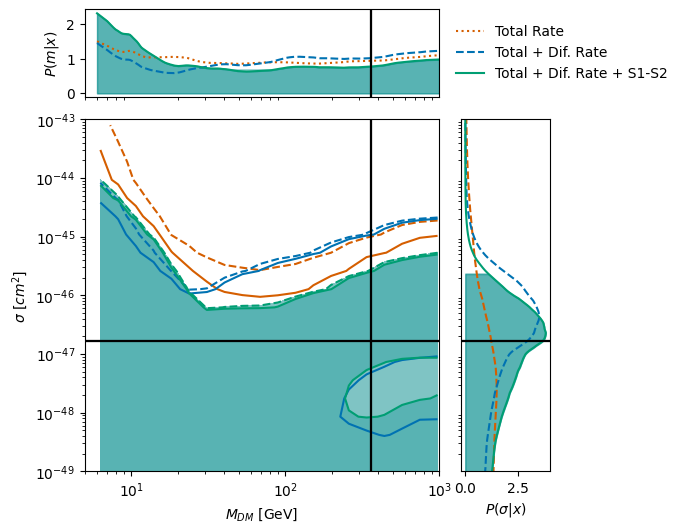

In [10]:
# Now let's make some plots to see the results


fig,ax = plt.subplots(2,2, figsize = (6,6),
                      gridspec_kw={'height_ratios': [0.5, 2], 'width_ratios':[2,0.5]})

plt.subplots_adjust(hspace = 0.1, wspace = 0.1)

batman.plot1d([logratios1D[0]], pars_prior, pars_true, ax[0,0], par = 0, fill = False, linestyle = ':', color = color_rate, pars_min = pars_min, pars_max = pars_max)
batman.plot1d([logratios1D[0], logratios1D[1]], pars_prior, pars_true, ax[0,0], par = 0, fill = False, linestyle = '--', color = color_drate, pars_min = pars_min, pars_max = pars_max)
batman.plot1d(logratios1D, pars_prior, pars_true, ax[0,0], par = 0, fill = True, linestyle = 'solid', color = color_s1s2, pars_min = pars_min, pars_max = pars_max)

batman.plot2d([logratios2D[0]], pars_prior, pars_true, ax[1,0], fill = False, line = True, linestyle = ':', color = color_rate, pars_min = pars_min, pars_max = pars_max)
batman.plot2d([logratios2D[0],logratios2D[1]], pars_prior, pars_true, ax[1,0], fill = False, line = True, linestyle = '--', color = color_drate, pars_min = pars_min, pars_max = pars_max)
batman.plot2d(logratios2D, pars_prior, pars_true, ax[1,0], fill = True, line = True, linestyle = 'solid', color = color_s1s2, pars_min = pars_min, pars_max = pars_max)

batman.plot1d([logratios1D[2]], pars_prior, pars_true, ax[1,1], par = 1, flip = True, fill = False, linestyle = '--', color = color_rate, pars_min = pars_min, pars_max = pars_max)
batman.plot1d([logratios1D[0], logratios1D[1]], pars_prior, pars_true, ax[1,1], par = 1, flip = True, fill = False, linestyle = '--', color = color_drate, pars_min = pars_min, pars_max = pars_max)
batman.plot1d(logratios1D, pars_prior, pars_true, ax[1,1], par = 1, flip = True, fill = True, linestyle = 'solid', color = color_s1s2, pars_min = pars_min, pars_max = pars_max)

ax[0,0].set_xlim(5,1e3)
ax[1,0].set_xlim(5,1e3)
ax[1,0].set_ylim(1e-49,1e-43)
ax[1,1].set_ylim(1e-49,1e-43)

ax[0,0].set_xlabel('')
ax[0,0].set_ylabel('$P(m|x)$')
ax[0,0].set_xticks([])
ax[1,1].set_ylabel('')
ax[1,1].set_yticks([])
ax[1,1].set_xlabel('$P(\sigma|x)$')

custom_lines = []
labels = ['Total Rate', 'Total + Dif. Rate', 'Total + Dif. Rate + S1-S2']
markers = [':','--', 'solid']
colors = [color_rate, color_drate, color_s1s2]
for i in range(3):
    custom_lines.append( Line2D([0],[0], linestyle = markers[i], color = colors[i],
            label = labels[i]) )

ax[0,1].axis('off')
ax[0,1].legend(handles = custom_lines, frameon = False, loc = 'lower left', bbox_to_anchor=(-0.2,0.05))